In [233]:
import atomai as aoi
from atomai.nets import ConvBlock, UpsampleBlock
from atomai.utils import set_train_rng
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import cv2
import numpy as np
from scipy.signal import convolve2d
import random

In [234]:
imgdata = np.load("../../graphene_MD_imgs.npy")[::10] # take ~1/3 of the data
print(imgdata.shape)

(605, 256, 256)


![image](image_from_paper/Real_ESRGAN.png)

In [235]:

import numpy as np
from scipy.ndimage import zoom
from PIL import Image

def add_blur(image):
    section=random.randint(0,1)
    if(section):
        sigma=random.randint(5,9)
        kernel_size = 19
        # Generate a 2D Gaussian blur kernel
        blur_kernel = cv2.getGaussianKernel(kernel_size, sigma)
        # Create a 2D Gaussian blur filter
        gaussian_blur_filter = np.outer(blur_kernel, blur_kernel)
        # Normalize the kernel
        gaussian_blur_filter /= np.sum(gaussian_blur_filter)
        blurred_image = cv2.filter2D(image, -1, gaussian_blur_filter)
    else:
        # Define the length and angle of motion blur
        kernel_length = 19
        kernel_angle=random.randint(3,9)
        #kernel_angle = 9  # Angle in degrees
        # Create a motion blur kernel
        motion_blur_kernel = np.zeros((kernel_length, kernel_length))
        row, col = kernel_length // 2, kernel_length // 2
        motion_blur_kernel[row, :] = np.sin(np.deg2rad(kernel_angle))
        motion_blur_kernel[row, col] = np.cos(np.deg2rad(kernel_angle))
        motion_blur_kernel /= np.sum(motion_blur_kernel)
        blurred_image = convolve2d(image, motion_blur_kernel, mode='same')
    return blurred_image



def resize(image,factor=0.25):
    image_array = image

    new_height = 300
    new_width = 400

    # Calculate the scaling factors for each dimension
    scale_factors = (
        new_height / image_array.shape[0],  # Height scaling factor
        new_width / image_array.shape[1]   # Width scaling factor
                                        # Depth or color channels scaling factor (1 for grayscale)
    )
    order=random.randint(1,4)
    # Resize the image using different interpolation methods
    resized_nearest = zoom(image_array, factor, order=0)
    resized_area = zoom(image_array, factor, order=3)
    resized_bilinear = zoom(image_array,factor, order=1)
    resized_bicubic = zoom(image_array, factor, order=2)
    if order==1:
        resize_image=resized_nearest
    elif order==2:
        resize_image=resized_area
    elif order==3:
        resize_image=resized_bilinear
    elif order==4:
        resize_image=resized_bicubic
    return resize_image

In [236]:
imgdata_noisy_resize = []
for i,image in enumerate (imgdata):
    blurred_image=add_blur(image)
    np.random.seed(5) # for reproducibility
    # Add noise to data
    resize_image=resize(blurred_image,factor=0.4)
    img_noisy = resize_image + np.random.normal(scale=8, size=resize_image.shape)
    #blurred_image=add_blur(imgdata_noisy)
    resize_image=resize(blurred_image,factor=1)
    # Add noise to data
    #img_noisy = resize_image + np.random.normal(scale=8, size=resize_image.shape)
    imgdata_noisy_resize.append(blurred_image)

imgdata_noisy_resize=np.array(imgdata_noisy_resize)

np.random.seed(5) # for reproducibility
# Add noise to data
imgdata_noisy = imgdata + np.random.normal(scale=8, size=imgdata.shape)


for i ,data in enumerate(imgdata_noisy):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    imgdata_noisy[i]=normalized_data
for i ,data in enumerate(imgdata_noisy_resize):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    imgdata_noisy_resize[i]=normalized_data

for i ,data in enumerate(imgdata):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    imgdata[i]=normalized_data

Text(0.5, 1.0, 'Noisy and resized image')

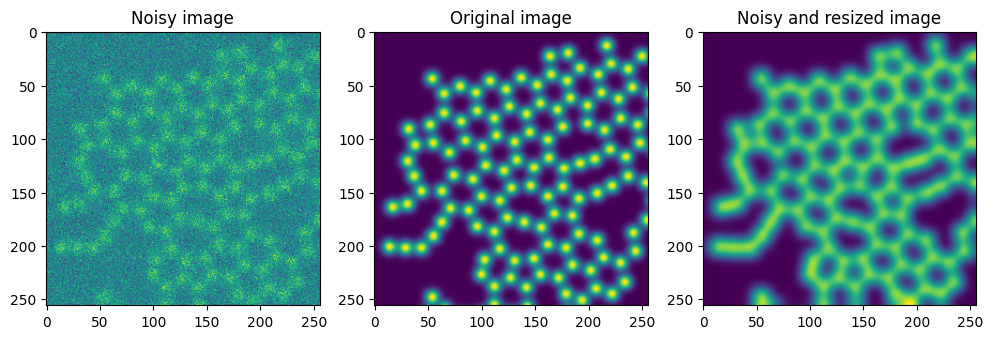

In [238]:
k = 205

_, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.imshow(imgdata_noisy[k])
ax2.imshow(imgdata[k])
ax3.imshow(imgdata_noisy_resize[k])
ax1.set_title("Noisy image")
ax2.set_title("Original image")
ax3.set_title("Noisy and resized image")

In [239]:
train_ratio = 0.7
test_ratio = 0.3

total_samples = len(imgdata)
num_train_samples = int(train_ratio * total_samples)
num_test_samples = total_samples - num_train_samples
print(total_samples,num_train_samples,num_test_samples)


# Create a random index permutation to shuffle the data
indices = np.random.permutation(total_samples)

# Use array slicing to split the data into training and test sets
output_train= np.float32(imgdata[:num_train_samples][::][::])
input_train  = np.float32(imgdata_noisy_resize[:num_train_samples][::][::])

output_test = np.float32(imgdata[num_train_samples:][::][::])
input_test = np.float32(imgdata_noisy_resize[num_train_samples:][::][::])

# Print the shapes of the resulting training and test sets
print("Input Training Set Shape:", input_train.shape)
print("Output Training Set Shape:", output_train.shape)
print("Input Test Set Shape:", input_test.shape)
print("Output Test Set Shape:", output_test.shape)

605 423 182
Input Training Set Shape: (423, 256, 256)
Output Training Set Shape: (423, 256, 256)
Input Test Set Shape: (182, 256, 256)
Output Test Set Shape: (182, 256, 256)


In [209]:
type(input_train[0][0][0])

numpy.float32

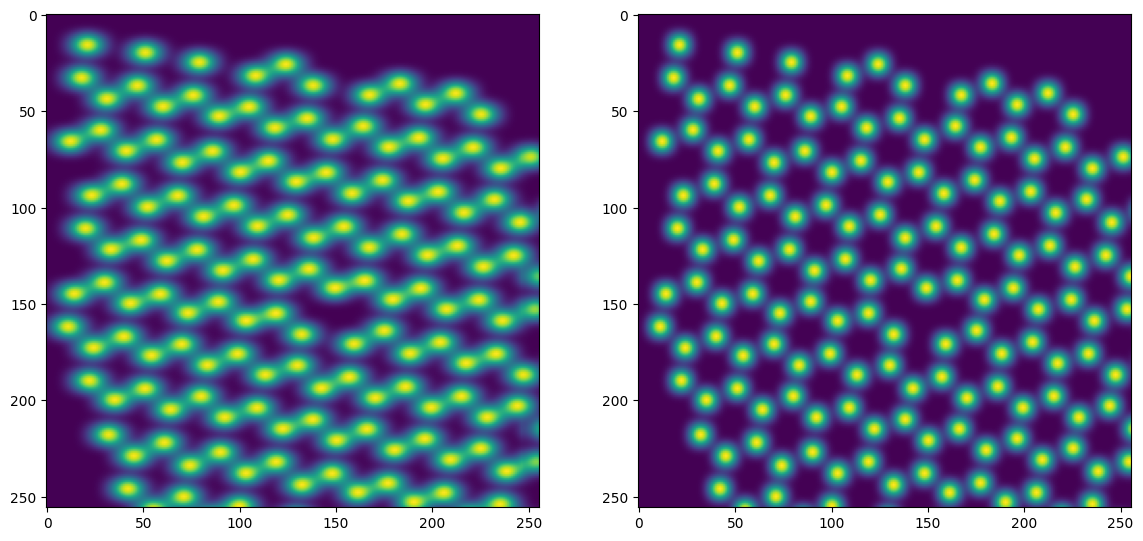

In [240]:
fig,ax =plt.subplots(1,2,figsize=(14,7))
ax[0].imshow(input_train[1])
ax[1].imshow(output_train[1])

In [175]:
torch_encoder = torch.nn.Sequential(
    ConvBlock(ndim=2, nb_layers=1, input_channels=1, output_channels=8, batch_norm=True),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 8, 16, batch_norm=False),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 16, 32, batch_norm=False),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 32, 64, batch_norm=False)  # technically, this is a "bottleneck layer"
)

torch_decoder = torch.nn.Sequential(
    UpsampleBlock(ndim=2, input_channels=64, output_channels=64, mode="nearest"), # bilinear mode is better but leads to uncontrolled randomness on CPU
    ConvBlock(2, 2, 64, 32, batch_norm=False),
    UpsampleBlock(2, 32, 32, mode="nearest"),  # we can also use it to reduce numbe of "channels"
    ConvBlock(2, 2, 32, 16, batch_norm=False),
    UpsampleBlock(2, 16, 16, mode="nearest"),
    ConvBlock(2, 1, 16, 8, batch_norm=False),
    torch.nn.Conv2d(8, 1, 1) # vanilla 2D convolutional layer without activation
)

torch_DAE = torch.nn.Sequential(torch_encoder, torch_decoder)

In [157]:
trainer = aoi.trainers.BaseTrainer()
trainer.set_model(torch_DAE)

In [158]:
set_train_rng(1)
trainer._reset_weights()
trainer._reset_training_history()

trainer.compile_trainer(
    (input_train, output_train, input_test, output_test), # training data
    loss="mse", training_cycles=500, swa=True  # training parameters
)

In [ ]:
trained_model = trainer.run()

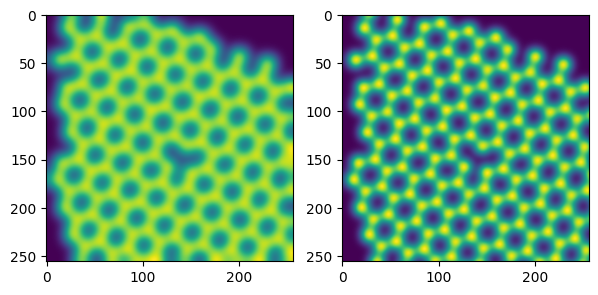

In [241]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, data_pairs, transform=None):
        self.data_pairs = data_pairs
        self.transform = transform

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        high_res,noisy_low_res = self.data_pairs[idx][0],self.data_pairs[idx][1]
       
        
        if self.transform:
            high_res = self.transform(high_res)
            noisy_low_res = self.transform(noisy_low_res)

        return noisy_low_res, high_res

# Define data transformations (resize and tensor conversion)
data_transform = transforms.Compose([
    #transforms.Resize((256, 256)),  # Resize to high-res size
    transforms.ToTensor(),  # Convert to tensors
])

train_dataset = CustomDataset(data_pairs=list(zip(input_train, output_train)), transform=None)
test_dataset = CustomDataset(data_pairs=list(zip(input_test, output_test)), transform=None)


data_pairs=list(zip(input_train, output_train))
fig,ax = plt.subplots(1,2,figsize=(7,15))
ax[0].imshow(data_pairs[5][0])
ax[1].imshow(data_pairs[5][1])

In [109]:
torch_encoder = torch.nn.Sequential(
    ConvBlock(ndim=2, nb_layers=1, input_channels=1, output_channels=8, batch_norm=True),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 8, 16, batch_norm=False),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 16, 32, batch_norm=False),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 32, 64, batch_norm=False)  # technically, this is a "bottleneck layer"
)

torch_decoder = torch.nn.Sequential(
    UpsampleBlock(ndim=2, input_channels=64, output_channels=64, mode="nearest"), # bilinear mode is better but leads to uncontrolled randomness on CPU
    ConvBlock(2, 2, 64, 32, batch_norm=False),
    UpsampleBlock(2, 32, 32, mode="nearest"),  # we can also use it to reduce numbe of "channels"
    ConvBlock(2, 2, 32, 16, batch_norm=False),
    UpsampleBlock(2, 16, 16, mode="nearest"),
    ConvBlock(2, 1, 16, 8, batch_norm=False),
    torch.nn.Conv2d(8, 1, 1) # vanilla 2D convolutional layer without activation
)

torch_DAE = torch.nn.Sequential(torch_encoder, torch_decoder)

In [242]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import SSIM


class GeneratorAtomAI(nn.Module):
    def __init__(self):
        super(GeneratorAtomAI, self).__init__()

        self.encoder = nn.Sequential(
            ConvBlock(ndim=2, nb_layers=1, input_channels=1, output_channels=8, batch_norm=True),
            torch.nn.MaxPool2d(2, 2),
            ConvBlock(2, 2, 8, 16, batch_norm=False),
            torch.nn.MaxPool2d(2, 2),
            ConvBlock(2, 2, 16, 32, batch_norm=False),
            torch.nn.MaxPool2d(2, 2),
            ConvBlock(2, 2, 32, 64, batch_norm=False)  # technically, this is a "bottleneck layer"
        )
        self.decoder = nn.Sequential(
            UpsampleBlock(ndim=2, input_channels=64, output_channels=64, mode="nearest"), # bilinear mode is better but leads to uncontrolled randomness on CPU
            ConvBlock(2, 2, 64, 32, batch_norm=False),
            UpsampleBlock(2, 32, 32, mode="nearest"),  # we can also use it to reduce numbe of "channels"
            ConvBlock(2, 2, 32, 16, batch_norm=False),
            UpsampleBlock(2, 16, 16, mode="nearest"),
            ConvBlock(2, 1, 16, 8, batch_norm=False),
            torch.nn.Conv2d(8, 1, 1) # vanilla 2D convolutional layer without activation
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define your ResNet-based generator
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



class EDRNGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EDRNGenerator, self).__init__()

        # Initial Convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # EDRN Blocks (Adjust the number of blocks as needed)
        self.edrn_blocks = nn.Sequential(
            self._make_edrn_block(64, 128),
            self._make_edrn_block(128, 128),
            self._make_edrn_block(128, 256),
            self._make_edrn_block(256, 256),
            self._make_edrn_block(256, 512)
        )

        # Final Convolution
        self.final_conv = nn.Sequential(
            nn.Conv2d(512, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.edrn_blocks(x)
        x = self.final_conv(x)
        return x

    def _make_edrn_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    

# Define your U-Net-based criterion (loss)
class UNetCriterion_mse(nn.Module):
    def __init__(self):
        super(UNetCriterion_mse, self).__init__()

    def forward(self, output, target):
        # Calculate the U-Net-based loss (you can customize this)
        loss = F.mse_loss(output, target)  # Example: Mean Squared Error loss
        return loss
    

# Define the U-Net architecture
class UNetCriterion(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetCriterion, self).__init__()

        # Define the U-Net encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the U-Net decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()  # Sigmoid activation for pixel values in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [243]:
from pytorch_msssim import SSIM
from piq import ssim, SSIMLoss



# Define your U-Net-based criterion (loss)
class UNetCriterion_mse(nn.Module):
    def __init__(self):
        super(UNetCriterion_mse, self).__init__()

    def forward(self, output, target):
        # Calculate the U-Net-based loss (you can customize this)
        loss = F.mse_loss(output, target)  # Example: Mean Squared Error loss
        return loss
    

x = torch.rand(4, 1, 256, 256, requires_grad=True)
y = torch.rand(4, 1, 256, 256)

ssim_index: torch.Tensor = ssim(x, y, data_range=1.)
#print(ssim_index)
loss = SSIMLoss(data_range=1.)

output: torch.Tensor = loss(x, y)
print("SSIMLoss",output.item())
output.backward()




loss = UNetCriterion_mse()
output: torch.Tensor = 1.0-loss(x, y)
print("UNetCriterion_mse",(output.item()))
output.backward()




loss = nn.MSELoss()
output: torch.Tensor = 1.0-loss(x, y)
print("nn.mse",(output.item()))
output.backward()


loss = SSIM(win_size=11,data_range=1.0, size_average=True, channel=1)

output: torch.Tensor = 1.0-loss(x, y)
print("PySSIM",(output.item()))
output.backward()

from skimage.metrics import structural_similarity as ssimsk
sumv=0
for i,dat in enumerate(x):
    ssim_value=ssimsk(x[i][0].detach().numpy(),y[i][0].detach().numpy(),data_range=1.0)
    sumv+=ssim_value

    print(f'ssim_value: {ssim_value:.5f}')
print(f'ssim_value: {1-sumv/4:.5f}')


SSIMLoss 0.9950647950172424
UNetCriterion_mse 0.8334293961524963
nn.mse 0.8334293961524963
PySSIM 0.9950645565986633
ssim_value: 0.00817
ssim_value: 0.00244
ssim_value: 0.00100
ssim_value: 0.00827
ssim_value: 0.99503


In [245]:
from IPython.display import HTML, display
from skimage.metrics import structural_similarity as ssim
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from piq import ssim, SSIMLoss


# Define your EDRNGenerator class (make sure it's correctly defined)

# Define data transformations (resize and tensor conversion)
data_transform = transforms.Compose([
   
    #transforms.Resize((256, 256)),  # Resize to high-res size
    transforms.ToTensor(),  # Convert to tensors
])


train_dataset = CustomDataset(data_pairs=list(zip(input_train, output_train)), transform=data_transform)
test_dataset = CustomDataset(data_pairs=list(zip(input_test, output_test)), transform=data_transform)

# Create DataLoader for training and testing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


generator = GeneratorAtomAI()  # Adjust input and output channels


# Define your loss function (e.g., MSE loss)

criterion= SSIMLoss(data_range=1.)

# Initialize the optimizer (e.g., Adam)
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    generator.train()  # Set the generator to training mode
    for batch in train_loader:
        noisy_low_res, high_res = batch[::][1],batch[::][0]
        # Forward pass
        generated_hr = generator(noisy_low_res)
        target_size = (256, 256)
# Use torch.nn.functional.interpolate to upsample to the target size
        generated_hr = F.interpolate(generated_hr, size=target_size, mode='bilinear', align_corners=False)
        # Compute loss
        min_value = generated_hr.min()
        max_value = generated_hr.max()
        generated_hr = (generated_hr - min_value) / (max_value - min_value)

        # Apply the transform to the tensor
        
        loss = criterion(generated_hr, high_res)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f'SIMLoss: {loss.item():.4f}')

    # Print training progress (e.g., loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(generator.state_dict(), 'esrgan_model_blur.pth')

Epoch [1/100], Loss: 0.8328
Epoch [2/100], Loss: 0.3164
Epoch [3/100], Loss: 0.2583
Epoch [4/100], Loss: 0.1236
Epoch [5/100], Loss: 0.2069
Epoch [6/100], Loss: 0.1927
Epoch [7/100], Loss: 0.1007
Epoch [8/100], Loss: 0.0815
Epoch [9/100], Loss: 0.0845
Epoch [10/100], Loss: 0.1850
Epoch [11/100], Loss: 0.0898
Epoch [12/100], Loss: 0.1159
Epoch [13/100], Loss: 0.0586
Epoch [14/100], Loss: 0.1076
Epoch [15/100], Loss: 0.0722
Epoch [16/100], Loss: 0.1153
Epoch [17/100], Loss: 0.1141
Epoch [18/100], Loss: 0.1392
Epoch [19/100], Loss: 0.1259
Epoch [20/100], Loss: 0.0993
Epoch [21/100], Loss: 0.0671
Epoch [22/100], Loss: 0.0721
Epoch [23/100], Loss: 0.0694
Epoch [24/100], Loss: 0.1092
Epoch [25/100], Loss: 0.0885
Epoch [26/100], Loss: 0.0922
Epoch [27/100], Loss: 0.0735
Epoch [28/100], Loss: 0.0723
Epoch [29/100], Loss: 0.0877
Epoch [30/100], Loss: 0.0483
Epoch [31/100], Loss: 0.0898
Epoch [32/100], Loss: 0.0549
Epoch [33/100], Loss: 0.0512
Epoch [34/100], Loss: 0.1064
Epoch [35/100], Loss: 0

In [218]:
import torch

# Step 1: Load the pre-trained model
model_path = 'esrgan_model_resize.pth'  # Replace with the path to your pre-trained model
in_channels = 1  # Number of input channels
out_channels = 1  # Number of output channels


# Create an instance of your EDRN-based generator
model =GeneratorAtomAI()
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Step 2: Prepare input data (replace this with your data loading/preprocessing code)
input_data = torch.randn(1,1,102, 102)  # Example input data, adjust dimensions as needed
input_data[0][0]=torch.Tensor(input_test[20])

print(input_data.size())
# Step 3: Perform a forward pass to make predictions
with torch.no_grad():  # Disable gradient calculation during inference
    predictions = model(input_data)

# The 'predictions' variable now contains the model's output

# You can post-process the predictions as needed
# For example, if it's a classification model, you can apply softmax to get class probabilities
# For regression, you might want to convert the tensor to a NumPy array, etc.

# Example post-processing:
if isinstance(predictions, torch.Tensor):
    print(predictions)
    predictions = predictions.cpu().numpy()  # Convert to NumPy array (if it's a tensor)

torch.Size([1, 1, 102, 102])
tensor([[[[0.0754, 0.0725, 0.0722,  ..., 0.0719, 0.0720, 0.0791],
          [0.0720, 0.0713, 0.0714,  ..., 0.0714, 0.0713, 0.0775],
          [0.0720, 0.0713, 0.0713,  ..., 0.0713, 0.0713, 0.0774],
          ...,
          [0.0719, 0.0713, 0.0713,  ..., 0.0715, 0.0716, 0.0776],
          [0.0720, 0.0714, 0.0714,  ..., 0.0717, 0.0719, 0.0777],
          [0.0835, 0.0994, 0.0993,  ..., 0.0995, 0.1000, 0.1025]]]])


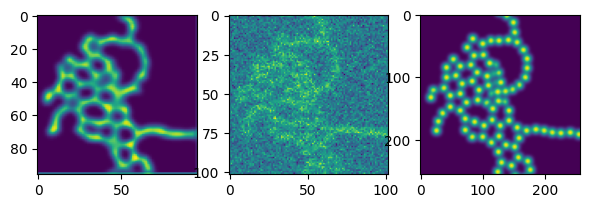

In [219]:
fig,ax = plt.subplots(1,3,figsize=(7,21))

ax[0].imshow(predictions[0][0])
ax[1].imshow(input_data[0][0])
ax[2].imshow(output_test[20])


In [220]:
expdata = np.load("../../graphene_exp.npy")
expdata = expdata * 60 # scale it to the range of pixel values used in training data

In [221]:
import torch

# Step 1: Load the pre-trained model
model_path = 'esrgan_model_resize.pth'  # Replace with the path to your pre-trained model
in_channels = 1  # Number of input channels
out_channels = 1  # Number of output channels


# Create an instance of your EDRN-based generator
model =GeneratorAtomAI()
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Step 2: Prepare input data (replace this with your data loading/preprocessing code)
input_data = torch.randn(1,1,1024, 1024)  # Example input data, adjust dimensions as needed
input_data[0][0]=torch.Tensor(expdata)

print(input_data.size())
# Step 3: Perform a forward pass to make predictions
with torch.no_grad():  # Disable gradient calculation during inference
    predictions = model(input_data)

# The 'predictions' variable now contains the model's output

# You can post-process the predictions as needed
# For example, if it's a classification model, you can apply softmax to get class probabilities
# For regression, you might want to convert the tensor to a NumPy array, etc.

# Example post-processing:
if isinstance(predictions, torch.Tensor):
    print(predictions)
    predictions = predictions.cpu().numpy()  # Convert to NumPy array (if it's a tensor)

torch.Size([1, 1, 1024, 1024])
tensor([[[[0.0911, 0.0843, 0.0765,  ..., 0.1105, 0.0894, 0.0798],
          [0.0857, 0.0808, 0.0706,  ..., 0.1113, 0.0876, 0.0777],
          [0.0828, 0.0782, 0.0700,  ..., 0.1026, 0.0861, 0.0786],
          ...,
          [0.0726, 0.0658, 0.0631,  ..., 0.1130, 0.1143, 0.1239],
          [0.0654, 0.0577, 0.0601,  ..., 0.1323, 0.1424, 0.1482],
          [0.0814, 0.0877, 0.0856,  ..., 0.1654, 0.1696, 0.1551]]]])


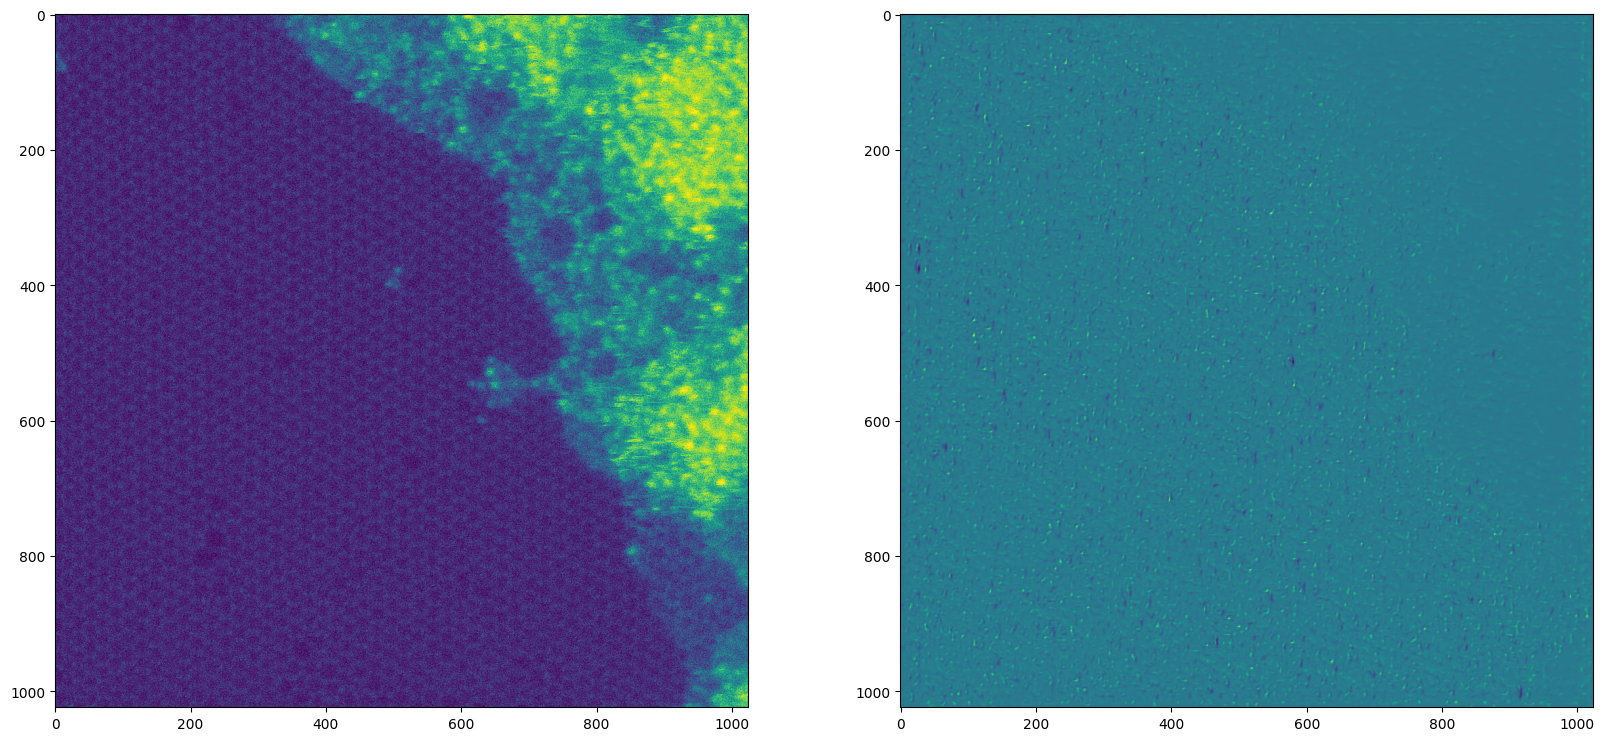

In [222]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(expdata)
ax2.imshow(predictions[0][0])

In [223]:
from os.path import join
import pySPM
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.ndimage import gaussian_filter
from scipy.fft import fftshift, fft2,ifftshift,ifft2,fft,fftfreq
from scipy.signal import hann
from sklearn import preprocessing as pre
from skimage import filters

In [224]:
def my_FFT(img):
    x_p=img.shape[0]
    image_bw=(img-img.min())/(img.max()-img.min())
    image_bw=img
    image_norm=pre.MinMaxScaler().fit_transform(img)
    window_hann = image_bw * hann(x_p, sym=True)
    ft = np.fft.fftshift(np.fft.fft2(window_hann))
    power_spectrum = np.abs(ft) ** 2
    return (power_spectrum-power_spectrum.min())/(power_spectrum.max()-power_spectrum.min())
def display_topo(image,fig,ax,x_n,y_n,title="SiC",scalecolor="white",scalesize=0.3,cmap="Blues_r"):
    #image=gaussian_filter(image,sigma=1)
    Z_image= pySPM.SPM_image(image)
    #Z_image.correct_median_diff()
    #Z_image.correct_lines()
    (y_p,x_p)=image.shape
    Z_image.size["real"]["x"],Z_image.size["real"]["y"]=x_n*1e-9,y_n*1e-9
    Z_image.size["pixels"]["y"],Z_image.size["pixels"]["x"]=y_p,x_p
    img=Z_image.show(ax=ax,sig=None,cmap=cmap)
    ax.axis ('off')
    Vmin=np.ndarray.min(Z_image.pixels) 
    Vmax=np.ndarray.max(Z_image.pixels) 
    cb=fig.colorbar(img,ax=ax,orientation="vertical",pad=0.02,shrink=0.8) 
    cb.ax.yaxis.set_tick_params(size=0.8,labeltop=True) 
    cb.set_ticks([Vmax,Vmin])
    cb.set_ticklabels(["High","Low"])
    scale=int(x_n/10) 
    scalebar=AnchoredSizeBar(ax.transData,scale*2,"{0} nm".format(scale*2),"lower right",pad=1,sep=3,color=scalecolor,label_top=True,frameon=False,size_vertical=scalesize)
    #ax.add_artist(scalebar)
    ax.set_title(title) 
    return img

def read_file(filePath):
    SXMfile=pySPM.SXM(filePath)
    header=SXMfile.header
    Bias=header['BIAS'][0][0]
    Curr=header['Z-CONTROLLER'][1][3]
    Z_image=SXMfile.get_channel('Z')
    #Z_image.correct_median_diff()
    Z_image.correct_lines()
    x_n,y_n=Z_image.size["real"]["x"]*1e9,Z_image.size["real"]["y"]*1e9
    y_p,x_p=Z_image.size["pixels"]["y"],Z_image.size["pixels"]["x"]
    print("the file is {0},\r\nthe Bias is {1} V,the current is {4} A, the size is {2}*{2} nm,the resolution is {3}*{3} pix ".format(filePath,float(Bias),int(x_n),x_p,Curr))
    return Z_image,x_n

the file is ../../../STMdata/20221206/SiC038.sxm,
the Bias is -0.18 V,the current is 8.000E-11 A, the size is 5*5 nm,the resolution is 512*512 pix 


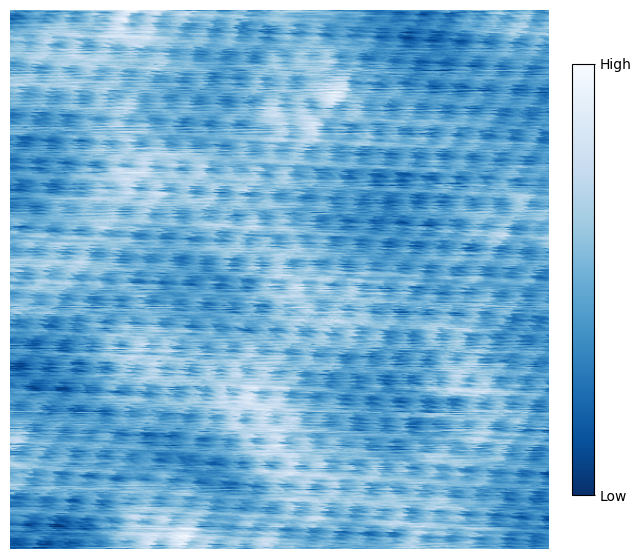

In [228]:
mydir,myFolder,fileName="../../../STMdata","20221206","SiC038.sxm"
filePath=join(mydir,myFolder,fileName)
Z_image,x_n=read_file(filePath)
y_n=x_n
image=Z_image.pixels[::-1,::]
x_p,y_p=image.shape[0],image.shape[1]
zoomFactor=0.12
zoomValue=int(x_p*zoomFactor)
fig,ax = plt.subplots(1,1,figsize=(15,7))
FFT_bw=my_FFT(image)
image=(image-image.min())/(image.max()-image.min())
LargeProfile=display_topo(image,fig,ax,x_n,y_n,title="",scalecolor="white",scalesize=0.15,cmap="Blues_r")

In [229]:
import torch

# Step 1: Load the pre-trained model
model_path = 'esrgan_model_resize.pth'  # Replace with the path to your pre-trained model
in_channels = 1  # Number of input channels
out_channels = 1  # Number of output channels


# Create an instance of your EDRN-based generator
model =GeneratorAtomAI()
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Step 2: Prepare input data (replace this with your data loading/preprocessing code)
input_data = torch.randn(1,1,512, 512)  # Example input data, adjust dimensions as needed
input_data[0][0]=torch.Tensor(image)

print(input_data.size())
# Step 3: Perform a forward pass to make predictions
with torch.no_grad():  # Disable gradient calculation during inference
    predictions = model(input_data)

# The 'predictions' variable now contains the model's output

# You can post-process the predictions as needed
# For example, if it's a classification model, you can apply softmax to get class probabilities
# For regression, you might want to convert the tensor to a NumPy array, etc.

# Example post-processing:
if isinstance(predictions, torch.Tensor):
    print(predictions)
    predictions = predictions.cpu().numpy()  # Convert to NumPy array (if it's a tensor)

torch.Size([1, 1, 512, 512])
tensor([[[[0.0754, 0.0725, 0.0722,  ..., 0.0720, 0.0721, 0.0793],
          [0.0720, 0.0713, 0.0714,  ..., 0.0715, 0.0716, 0.0777],
          [0.0720, 0.0713, 0.0713,  ..., 0.0714, 0.0715, 0.0776],
          ...,
          [0.0719, 0.0714, 0.0716,  ..., 0.0816, 0.0819, 0.0860],
          [0.0721, 0.0717, 0.0720,  ..., 0.0786, 0.0790, 0.0833],
          [0.0836, 0.0996, 0.1001,  ..., 0.1032, 0.1036, 0.1057]]]])


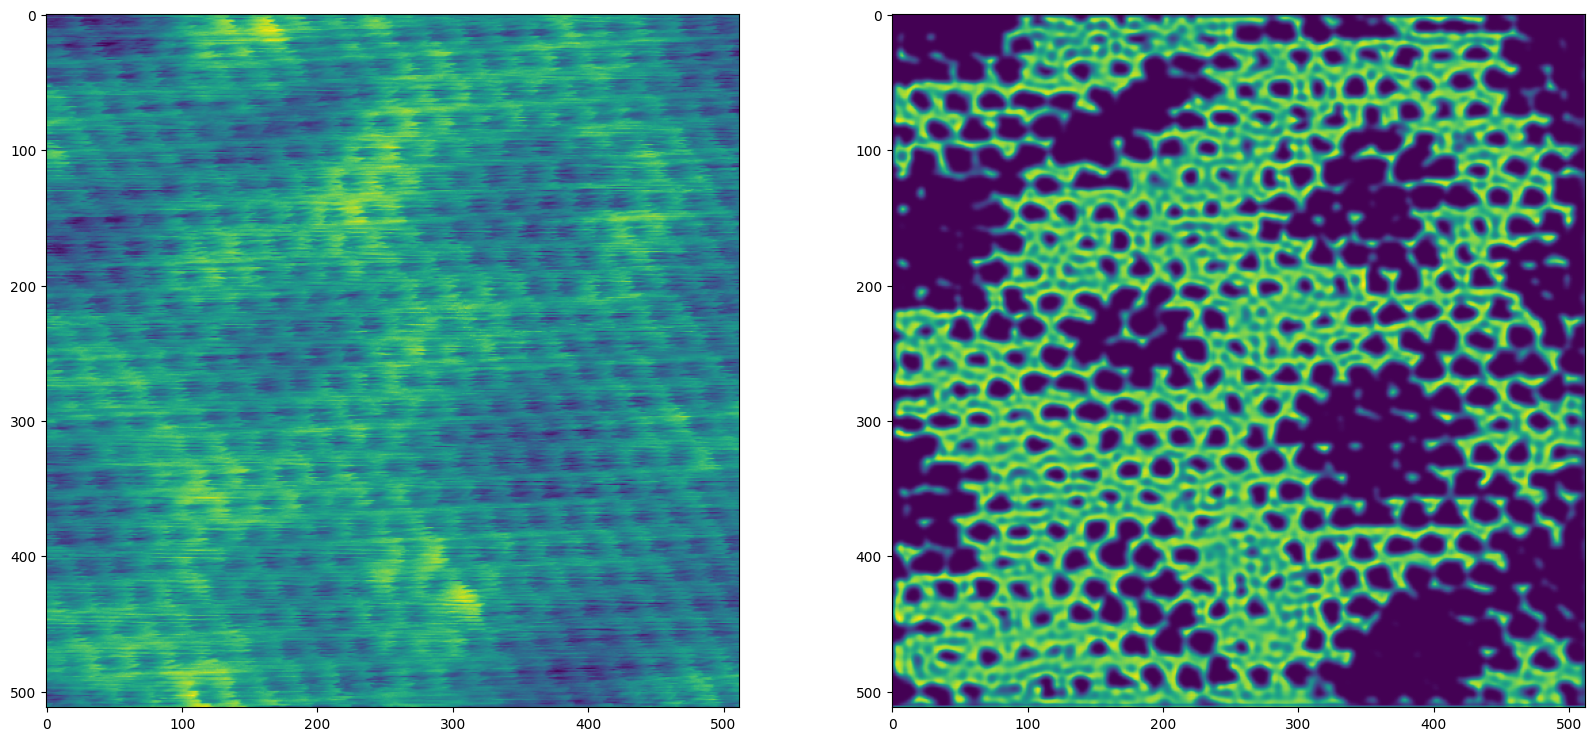

In [230]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(image)
ax2.imshow(predictions[0][0])

the file is ../../../STMdata/20221207/SiC011.sxm,
the Bias is -0.2 V,the current is 8.000E-11 A, the size is 20*20 nm,the resolution is 256*256 pix 
torch.Size([1, 1, 256, 256])
tensor([[[[0.0754, 0.0725, 0.0723,  ..., 0.0806, 0.0788, 0.0836],
          [0.0720, 0.0713, 0.0714,  ..., 0.0894, 0.0857, 0.0898],
          [0.0720, 0.0712, 0.0713,  ..., 0.1013, 0.0930, 0.0964],
          ...,
          [0.0752, 0.0794, 0.0867,  ..., 0.0887, 0.0861, 0.0885],
          [0.0754, 0.0790, 0.0848,  ..., 0.0847, 0.0830, 0.0853],
          [0.0854, 0.1039, 0.1097,  ..., 0.1068, 0.1053, 0.1071]]]])


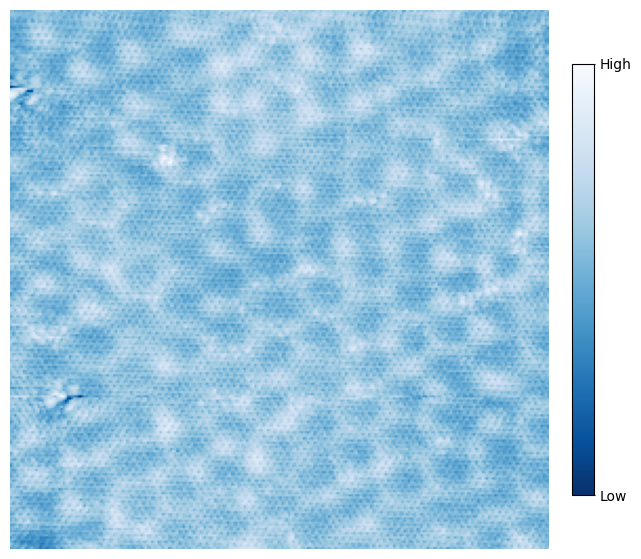

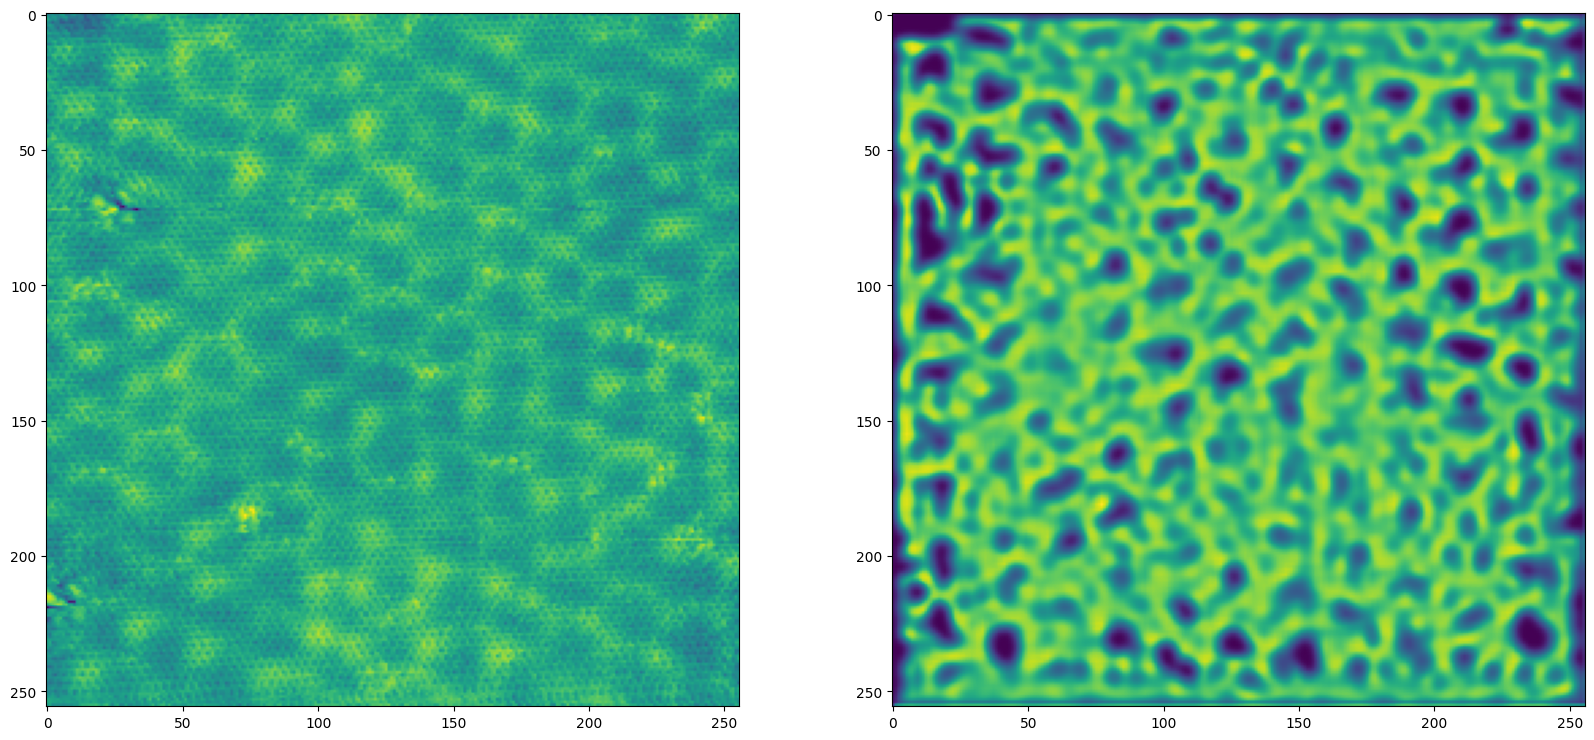

In [231]:
mydir,myFolder,fileName="../../../STMdata","20221207","SiC011.sxm"
filePath=join(mydir,myFolder,fileName)
Z_image,x_n=read_file(filePath)
y_n=x_n
image=Z_image.pixels[::-1,::]
x_p,y_p=image.shape[0],image.shape[1]
zoomFactor=0.12
zoomValue=int(x_p*zoomFactor)
fig,ax = plt.subplots(1,1,figsize=(15,7))
FFT_bw=my_FFT(image)
image=(image-image.min())/(image.max()-image.min())
LargeProfile=display_topo(image,fig,ax,x_n,y_n,title="",scalecolor="white",scalesize=0.15,cmap="Blues_r")


image_sig=copy.deepcopy(image)
image_sig[image_sig>0.9]=0.9
image_sig[image_sig<0.1]=0.1


import torch

# Step 1: Load the pre-trained model
model_path = 'esrgan_model_resize.pth'  # Replace with the path to your pre-trained model
in_channels = 1  # Number of input channels
out_channels = 1  # Number of output channels


# Create an instance of your EDRN-based generator
model =GeneratorAtomAI()
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Step 2: Prepare input data (replace this with your data loading/preprocessing code)
input_data = torch.randn(1,1,256, 256)  # Example input data, adjust dimensions as needed
input_data[0][0]=torch.Tensor(image)

print(input_data.size())
# Step 3: Perform a forward pass to make predictions
with torch.no_grad():  # Disable gradient calculation during inference
    predictions = model(input_data)

# The 'predictions' variable now contains the model's output

# You can post-process the predictions as needed
# For example, if it's a classification model, you can apply softmax to get class probabilities
# For regression, you might want to convert the tensor to a NumPy array, etc.

# Example post-processing:
if isinstance(predictions, torch.Tensor):
    print(predictions)
    predictions = predictions.cpu().numpy()  # Convert to NumPy array (if it's a tensor)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(image)
ax2.imshow(predictions[0][0])

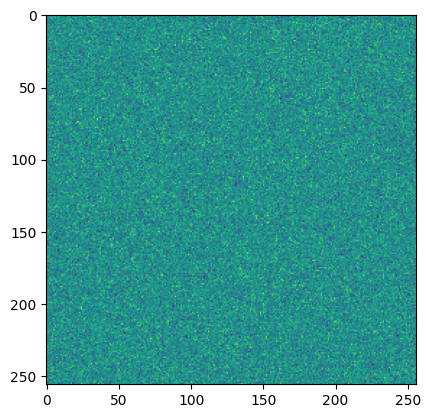

In [87]:
input_data
plt.imshow(input_data[0][0])

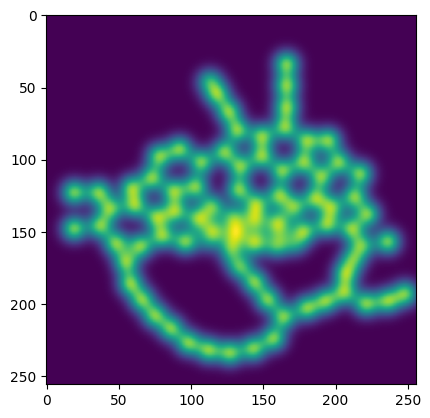

In [53]:
plt.imshow(output_test[10])

In [34]:
from IPython.display import HTML, display
from skimage.metrics import structural_similarity as ssim
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from piq import ssim, SSIMLoss





# Define your EDRNGenerator class (make sure it's correctly defined)

# Define data transformations (resize and tensor conversion)
data_transform = transforms.Compose([
   
    #transforms.Resize((256, 256)),  # Resize to high-res size
    transforms.ToTensor(),  # Convert to tensors
])


train_dataset = CustomDataset(data_pairs=list(zip(input_train, output_train)), transform=data_transform)
test_dataset = CustomDataset(data_pairs=list(zip(input_test, output_test)), transform=data_transform)

# Create DataLoader for training and testing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


generator = EDRNGenerator(in_channels=1, out_channels=1)  # Adjust input and output channels


# Define your loss function (e.g., MSE loss)

criterion= SSIMLoss(data_range=1.)

# Initialize the optimizer (e.g., Adam)
optimizer = torch.optim.Adam(generator.parameters(), lr=0.002)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    generator.train()  # Set the generator to training mode
    for batch in train_loader:
        noisy_low_res, high_res = batch[::][1],batch[::][0]
        # Forward pass
        generated_hr = generator(noisy_low_res)
        # Compute loss
        min_value = generated_hr.min()
        max_value = generated_hr.max()
        

        generated_hr = (generated_hr - min_value) / (max_value - min_value)

# Apply the transform to the tensor
        
        loss = criterion(generated_hr, high_res)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'SIMLoss: {loss.item():.4f}')

    # Print training progress (e.g., loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(generator.state_dict(), 'esrgan_model.pth')

SIMLoss: 0.9363
SIMLoss: 0.9467
SIMLoss: 0.8046
SIMLoss: 0.9135
SIMLoss: 0.8474
SIMLoss: 0.8342
SIMLoss: 0.8172


AssertionError: Expected values to be greater or equal to 0, got nan

In [24]:
#from skimage.metrics import structural_similarity as ssim
#from pytorch_msssim import SSIM
#from piqa import SSIM

In [22]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from piq import ssim, SSIMLoss


# Create an instance of your EDRNGenerator and initialize other components (e.g., criterion and optimizer)
class EDRNGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EDRNGenerator, self).__init__()

        # Initial Convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # EDRN Blocks (Adjust the number of blocks as needed)
        self.edrn_blocks = nn.Sequential(
            self._make_edrn_block(64, 128),
            self._make_edrn_block(128, 128),
            self._make_edrn_block(128, 256),
            self._make_edrn_block(256, 256),
            self._make_edrn_block(256, 512)
        )

        # Final Convolution
        self.final_conv = nn.Sequential(
            nn.Conv2d(512, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
         # Upsampling Layers
        #self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.edrn_blocks(x)
        x = self.final_conv(x)
        #x = self.upsample(x)
        return x

    def _make_edrn_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    








In [26]:

from IPython.display import HTML, display
from skimage.metrics import structural_similarity as ssim

# Define your EDRNGenerator class (make sure it's correctly defined)

# Define data transformations (resize and tensor conversion)
data_transform = transforms.Compose([
   
    #transforms.Resize((256, 256)),  # Resize to high-res size
    transforms.ToTensor(),  # Convert to tensors
])


train_dataset = CustomDataset(data_pairs=list(zip(input_train, output_train)), transform=data_transform)
test_dataset = CustomDataset(data_pairs=list(zip(input_test, output_test)), transform=data_transform)

# Create DataLoader for training and testing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#ssim_value=ssim(Z_backward,Z_forward,data_range=Z_forward.max()-Z_forward.min())

#print(f'ssim_value: {ssim_value:.2f}')

generator = EDRNGenerator(in_channels=1, out_channels=1).double()  # Adjust input and output channels








# Define your loss function (e.g., MSE loss)

criterion= SSIMLoss(data_range=1.)

# Initialize the optimizer (e.g., Adam)
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    generator.train()  # Set the generator to training mode
    for batch in train_loader:
        noisy_low_res, high_res = batch[::][1],batch[::][0]
        # Forward pass
        generated_hr = generator(noisy_low_res)
        # Compute loss
        loss = criterion(generated_hr, high_res)
        
        #loss =1.0- ssim_value
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print training progress (e.g., loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(generator.state_dict(), 'esrgan_model.pth')

: 

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import SSIM
from torchvision import transforms



# Define your ResNet-based generator
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



class EDRNGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EDRNGenerator, self).__init__()

        # Initial Convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # EDRN Blocks (Adjust the number of blocks as needed)
        self.edrn_blocks = nn.Sequential(
            self._make_edrn_block(64, 128),
            self._make_edrn_block(128, 128),
            self._make_edrn_block(128, 256),
            self._make_edrn_block(256, 256),
            self._make_edrn_block(256, 512)
        )

        # Final Convolution
        self.final_conv = nn.Sequential(
            nn.Conv2d(512, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.edrn_blocks(x)
        x = self.final_conv(x)
        return x

    def _make_edrn_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )




# Define your U-Net-based criterion (loss)
class UNetCriterion_mse(nn.Module):
    def __init__(self):
        super(UNetCriterion_mse, self).__init__()

    def forward(self, output, target):
        # Calculate the U-Net-based loss (you can customize this)
        loss = F.mse_loss(output, target)  # Example: Mean Squared Error loss
        return loss
    

# Define the U-Net architecture
class UNetCriterion(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetCriterion, self).__init__()

        # Define the U-Net encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the U-Net decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()  # Sigmoid activation for pixel values in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Define data transformations (resize and tensor conversion)
data_transform = transforms.Compose([
   
    #transforms.Resize((256, 256)),  # Resize to high-res size
    transforms.ToTensor(),  # Convert to tensors
])


train_dataset = CustomDataset(data_pairs=list(zip(input_train, output_train)), transform=data_transform)
test_dataset = CustomDataset(data_pairs=list(zip(input_test, output_test)), transform=data_transform)

# Create DataLoader for training and testing
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# In the context of a GAN, you would use this loss to measure the difference between
# the generated images and the target images produced by the discriminator.



# Example usage:
# Define input and output channel dimensions based on your data
in_channels = 1  # Number of input channels
out_channels = 1  # Number of output channels


# Create an instance of your EDRN-based generator
generator = EDRNGenerator(in_channels, out_channels).double()

# Create an instance of your generator and criterion
#generator = Generator(in_channels, out_channels)
criterion = UNetCriterion_mse()
criterion = SSIM(win_size=11,data_range=1.0, size_average=True, channel=1)

# Test your generator and criterion
#input_data = torch.randn(1, in_channels, 256, 256)  # Example input data (adjust dimensions as needed)

#noisy_data = torch.randn(1, in_channels, 64, 64)  # Example noisy data with different spatial dimensions


optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    generator.train()  # Set the generator to training mode
    for batch in train_loader:
        noisy_low_res, high_res = batch[::][1],batch[::][0]
        # Forward pass
        generated_hr = generator(noisy_low_res)
        # Compute loss
        loss =1.0- criterion(generated_hr, high_res)
        
        #loss =1.0- ssim_value
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("noisy_data.shape",noisy_low_res.shape)
        print("output_data.shape",generated_hr.shape)
        # Calculate loss using the criterion
        loss = criterion(generated_hr, noisy_low_res)
        print(f"Loss: {loss.item()}")
        ssim_value = criterion(generated_hr, noisy_low_res)

    # Print training progress (e.g., loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Test your generator and criterion
input_data = torch.randn(1, in_channels, 256, 256)  # Example input data (adjust dimensions as needed)

noisy_data = torch.randn(1, in_channels, 64, 64)  # Example noisy data with different spatial dimensions

# Resize or crop noisy_data to match the spatial dimensions of input_data
noisy_data = F.interpolate(noisy_data, size=input_data.shape[2:], mode='bilinear', align_corners=False)

# Generate output using the generator
output_data = generator(input_data)
print("noisy_data.shape",noisy_data.shape)
print("output_data.shape",output_data.shape)
# Calculate loss using the criterion
loss = criterion(output_data, noisy_data)
print(f"Loss: {loss.item()}")
ssim_value = criterion(output_data, noisy_data)

# Clear gradients


print(f"SSIM Loss: {1 - ssim_value.item()}")  # The SSIM loss is typically reported as 1 - SSIM value

noisy_data.shape torch.Size([4, 1, 256, 256])
output_data.shape torch.Size([4, 1, 256, 256])
Loss: 0.07565155971527698
noisy_data.shape torch.Size([4, 1, 256, 256])
output_data.shape torch.Size([4, 1, 256, 256])
Loss: 0.07855917373156035
noisy_data.shape torch.Size([4, 1, 256, 256])
output_data.shape torch.Size([4, 1, 256, 256])
Loss: 0.080206960507974
noisy_data.shape torch.Size([4, 1, 256, 256])
output_data.shape torch.Size([4, 1, 256, 256])
Loss: 0.08128508125371142
noisy_data.shape torch.Size([4, 1, 256, 256])
output_data.shape torch.Size([4, 1, 256, 256])
Loss: 0.07710002119810003


In [12]:
from torch.utils.data import DataLoader
generator = EDRNGenerator(in_channels=1, out_channels=1)


# Initialize the modified generator (ESRGenerator) as previously defined

# Create DataLoader for training and testing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define your loss function (e.g., MSE loss)
criterion = nn.MSELoss()
criterion=UNetCriterion_mse()

# Initialize the optimizer (e.g., Adam)
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    generator.train()  # Set the generator to training mode
    for batch in train_loader:
        noisy_low_res, high_res = batch

        # Forward pass
        generated_hr = generator(noisy_low_res)

        # Compute loss
        loss = criterion(generated_hr, high_res)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print training progress (e.g., loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(generator.state_dict(), 'esrgan_model.pth')

NameError: name 'EDRNGenerator' is not defined

In [18]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

class ESRGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ESRGenerator, self).__init__()
        # Modify the layers of your generator architecture accordingly
        # Example layers (modify as needed):
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        # ...

    def forward(self, x):
        # Implement the forward pass of your generator
        # Example forward pass (modify as needed):
        x = self.conv1(x)
        # ...

# Initialize the modified generator
generator = ESRGenerator(in_channels=1, out_channels=1)


# Initialize the modified generator (ESRGenerator) as previously defined

# Create DataLoader for training and testing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define your loss function (e.g., MSE loss)
criterion = nn.MSELoss()

# Initialize the optimizer (e.g., Adam)
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    generator.train()  # Set the generator to training mode
    for batch in train_loader:
        noisy_low_res, high_res = batch

        # Forward pass
        generated_hr = generator(noisy_low_res)

        # Compute loss
        loss = criterion(generated_hr, high_res)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print training progress (e.g., loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(generator.state_dict(), 'esrgan_model.pth')


ValueError: too many values to unpack (expected 2)

In [17]:
generator.eval()  # Set the generator to evaluation mode

# Test the model
test_loss = 0.0

with torch.no_grad():
    for batch in test_loader:
        noisy_low_res, high_res = batch
        generated_hr = generator(noisy_low_res)
        test_loss += criterion(generated_hr, high_res).item()

# Calculate and print the average test loss
average_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {average_test_loss:.4f}')

NameError: name 'generator' is not defined

In [165]:
import torch

# Step 1: Load the pre-trained model
model_path = 'esrgan_model.pth'  # Replace with the path to your pre-trained model
in_channels = 1  # Number of input channels
out_channels = 1  # Number of output channels


# Create an instance of your EDRN-based generator
model =EDRNGenerator(in_channels, out_channels)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Step 2: Prepare input data (replace this with your data loading/preprocessing code)
input_data = torch.randn(1,1,64, 64)  # Example input data, adjust dimensions as needed
input_data[0][0]=torch.Tensor(output_test[10])
# Step 3: Perform a forward pass to make predictions
with torch.no_grad():  # Disable gradient calculation during inference
    predictions = model(input_data)

# The 'predictions' variable now contains the model's output

# You can post-process the predictions as needed
# For example, if it's a classification model, you can apply softmax to get class probabilities
# For regression, you might want to convert the tensor to a NumPy array, etc.

# Example post-processing:
if isinstance(predictions, torch.Tensor):
    print(predictions)
    predictions = predictions.cpu().numpy()  # Convert to NumPy array (if it's a tensor)

RuntimeError: Error(s) in loading state_dict for EDRNGenerator:
	Missing key(s) in state_dict: "initial_conv.0.weight", "initial_conv.0.bias", "edrn_blocks.0.0.weight", "edrn_blocks.0.0.bias", "edrn_blocks.0.2.weight", "edrn_blocks.0.2.bias", "edrn_blocks.1.0.weight", "edrn_blocks.1.0.bias", "edrn_blocks.1.2.weight", "edrn_blocks.1.2.bias", "edrn_blocks.2.0.weight", "edrn_blocks.2.0.bias", "edrn_blocks.2.2.weight", "edrn_blocks.2.2.bias", "edrn_blocks.3.0.weight", "edrn_blocks.3.0.bias", "edrn_blocks.3.2.weight", "edrn_blocks.3.2.bias", "edrn_blocks.4.0.weight", "edrn_blocks.4.0.bias", "edrn_blocks.4.2.weight", "edrn_blocks.4.2.bias", "final_conv.0.weight", "final_conv.0.bias". 
	Unexpected key(s) in state_dict: "encoder.0.block.0.weight", "encoder.0.block.0.bias", "encoder.0.block.2.weight", "encoder.0.block.2.bias", "encoder.0.block.2.running_mean", "encoder.0.block.2.running_var", "encoder.0.block.2.num_batches_tracked", "encoder.2.block.0.weight", "encoder.2.block.0.bias", "encoder.2.block.2.weight", "encoder.2.block.2.bias", "encoder.4.block.0.weight", "encoder.4.block.0.bias", "encoder.4.block.2.weight", "encoder.4.block.2.bias", "encoder.6.block.0.weight", "encoder.6.block.0.bias", "encoder.6.block.2.weight", "encoder.6.block.2.bias", "decoder.0.conv.weight", "decoder.0.conv.bias", "decoder.1.block.0.weight", "decoder.1.block.0.bias", "decoder.1.block.2.weight", "decoder.1.block.2.bias", "decoder.2.conv.weight", "decoder.2.conv.bias", "decoder.3.block.0.weight", "decoder.3.block.0.bias", "decoder.3.block.2.weight", "decoder.3.block.2.bias", "decoder.4.conv.weight", "decoder.4.conv.bias", "decoder.5.block.0.weight", "decoder.5.block.0.bias", "decoder.6.weight", "decoder.6.bias". 

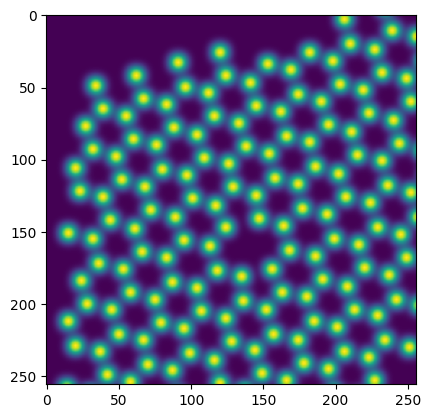

In [15]:
plt.imshow(input_train[10])

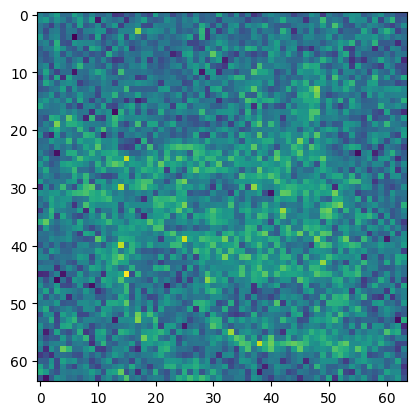

In [16]:
plt.imshow(output_test[0])

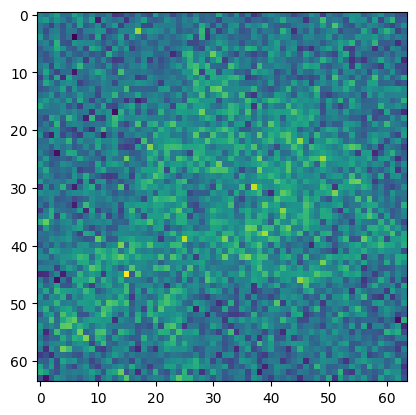

In [17]:
input_data
plt.imshow(input_data[0][0])

<class 'numpy.ndarray'>
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


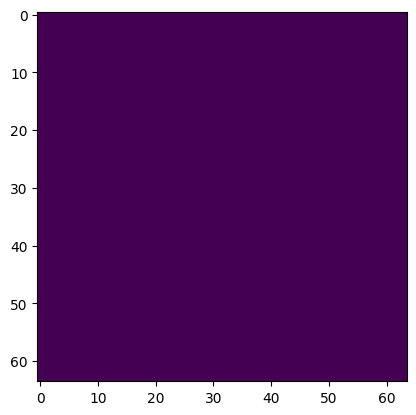

In [18]:
print(type(predictions))
plt.imshow(predictions[0][0])


print(predictions[0][0])